In [8]:
library('ggplot2')
library('reshape2')
library('ggpubr')
library(glmnet)
library(doMC)
library(survival)
library(data.table)
library(mltools)
library(CoxBoost)
library(randomForestSRC)
library(CoxHD)
library(Hmisc)
library(gridExtra)
library("survminer")
library(dplyr)
library(stringr)
options(warn = -1)
library(grid)
source("../../../../src/tools.R")
options(repr.plot.res        = 100, # set a medium-definition resolution for the jupyter notebooks plots (DPI)
        repr.matrix.max.rows = 250, # set the maximum number of rows displayed
        repr.matrix.max.cols = 250) # set the maximum number of columns displayed

In [2]:
df_final <- read.table("../../../clustering/clustering_Final_1/df_final_full_component.tsv")
eln <- colnames(df_final[,c(2,3,4)])
comp <- colnames(df_final[,c(170:186)])

all_gen <- c(5:88)
vect <- apply(X=df_final[,all_gen],2,FUN=function(x) 100*length(which(x==1))/dim(df_final)[1])
gen <- colnames(df_final[,match(names(vect[vect>=2]),names(df_final))])
              
all_cyto <- c(89:158)
vect <- apply(X=df_final[,all_cyto],2,FUN=function(x) 100*length(which(x==1))/dim(df_final)[1])
cyto <- colnames(df_final[,match(names(vect[vect>=2]),names(df_final))])
              
clin <- colnames(df_final[,c(159:165)])
demo <- colnames(df_final[,c(166:167)])
age <- "age"

gen_cyto <- c(gen,cyto)
eln_gen_cyto <- c(eln,gen,cyto)
comp_gen_cyto <- c(comp,gen,cyto)
comp_gen <- c(comp,gen)              
comp_cyto <- c(comp,cyto)
all <- c(eln,comp,gen,cyto,demo)              
pal <- c(eln="#EE9937",comp="#59A08B",gen="#BFBFBF",cyto="#2b8cbe",clin="#870C14",demo="#a6bddb",age="#a6bddb",gen_cyto="pink",eln_gen_cyto="#fdbb84",comp_gen_cyto="lightgoldenrod",all="lightsalmon")  
cols_component <- colnames(df_final %>% dplyr:: select(starts_with("full_component_")))

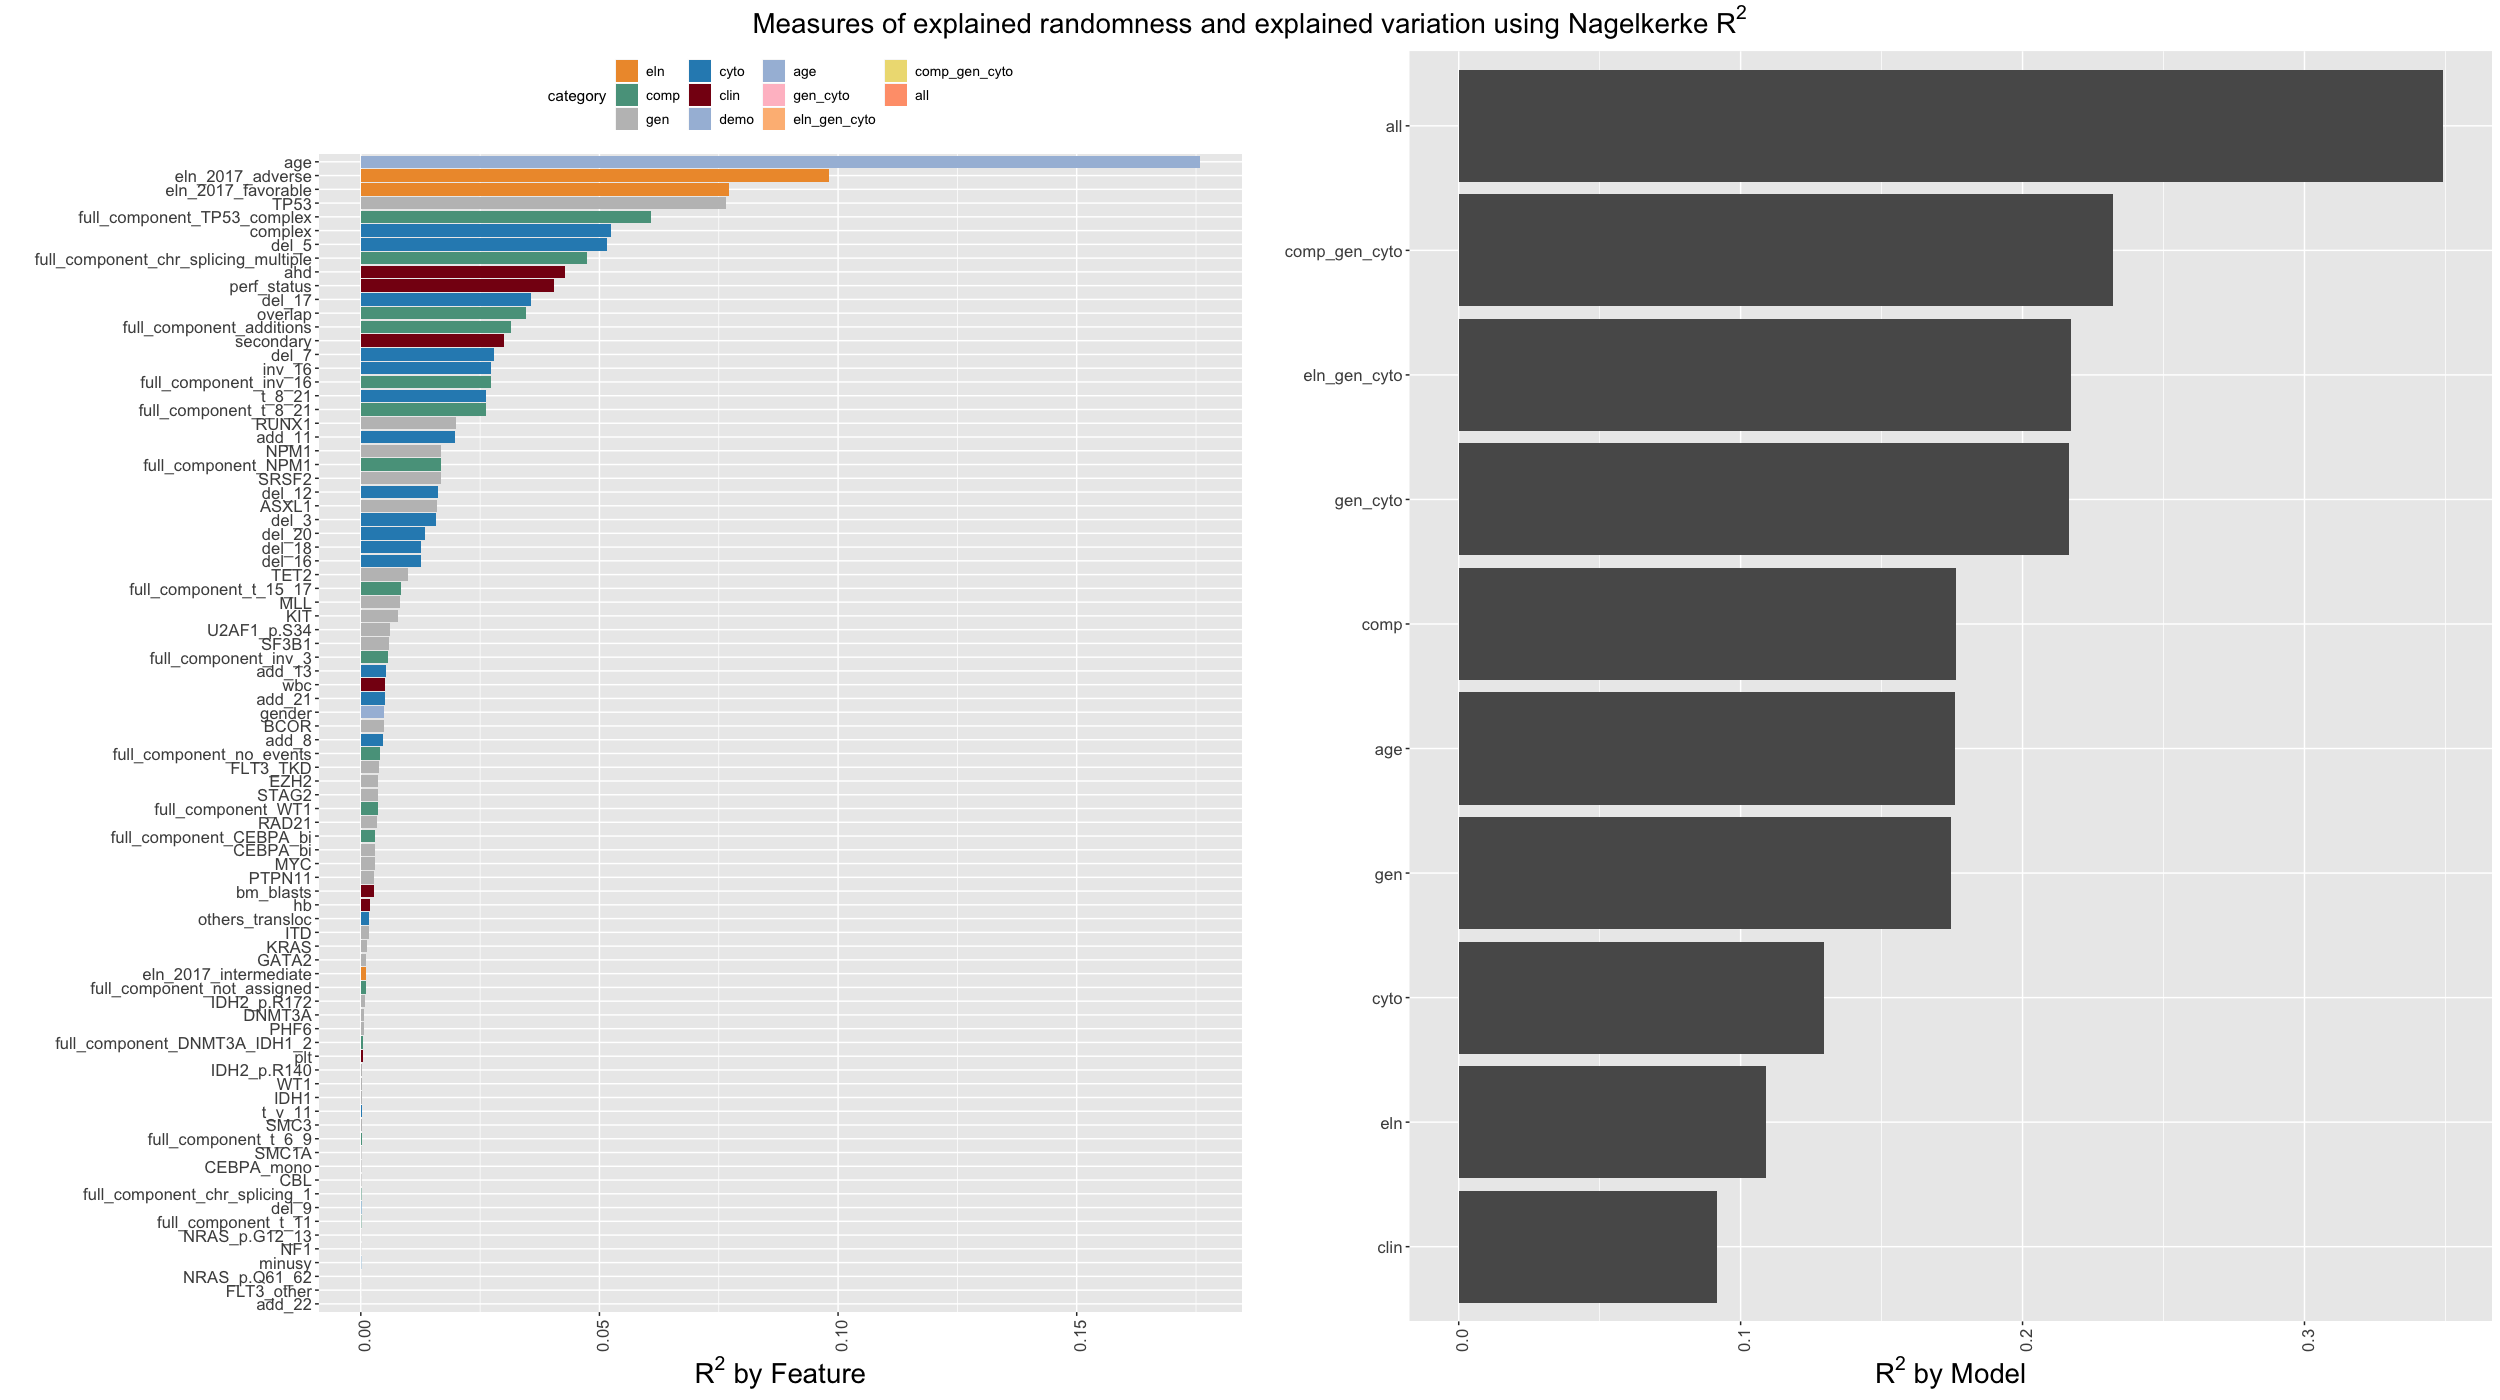

In [16]:
tmp <- df_final
df <- data.frame(R_squared = double(),concordance = double())
for (g in c(eln,comp,gen,cyto,clin,demo)){
    m <- coxph(as.formula(paste("Surv(os, os_status) ~ ",g,sep="")),tmp)
    df[g,] <- c(summary(m)$rsq[[1]],summary(m)$concordance)
}
df["feature"] <- rownames(df)
df["category"] <- ifelse(is.element(df$feature,eln),"eln",
                                       ifelse(is.element(df$feature,comp),"comp",
                                             ifelse(is.element(df$feature,gen),"gen",
                                                   ifelse(is.element(df$feature,cyto),"cyto",
                                                         ifelse(is.element(df$feature,clin),"clin","demo")))))
set_notebook_plot_size(25,14)
p <- ggplot(df,aes(x=reorder(feature,R_squared),y=R_squared,fill=category))+geom_bar(stat = "identity") +
        theme(plot.title = element_text( size=30, face="bold.italic",hjust=0.5),legend.text=element_text(size=10),legend.position="top",
          axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8,size=12),axis.text.y=element_text(size=12),
          axis.title.y = element_text(size = 20),axis.title.x = element_text(size = 20),strip.text = element_text(size=25))+
        ylab(expression(paste(R^2," by Feature"))) + xlab("") + coord_flip() + scale_fill_manual(values=pal,limits=names(pal))

df <- data.frame(R_squared = double(),concordance = double())

m <- coxph(as.formula(paste("Surv(os, os_status) ~ ",
                       paste(colnames(df_final[,cols_component]), collapse= "+"))), tmp) 
df["comp",] <- c(summary(m)$rsq[[1]],summary(m)$concordance)


m <- coxph(as.formula(paste("Surv(os, os_status) ~ ",
                       paste(colnames(df_final[,eln]), collapse= "+"))), tmp) 
df["eln",] <- c(summary(m)$rsq[[1]],summary(m)$concordance)

m <- coxph(as.formula(paste("Surv(os, os_status) ~ ",
                       paste(colnames(df_final[,gen]), collapse= "+"))), tmp) 
df["gen",] <- c(summary(m)$rsq[[1]],summary(m)$concordance)

m <- coxph(as.formula(paste("Surv(os, os_status) ~ ",
                       paste(colnames(df_final[,cyto]), collapse= "+"))), tmp) 
df["cyto",] <- c(summary(m)$rsq[[1]],summary(m)$concordance)

m <- coxph(as.formula(paste("Surv(os, os_status) ~ ",
                       paste(colnames(df_final[,clin]), collapse= "+"))), tmp) 
df["clin",] <- c(summary(m)$rsq[[1]],summary(m)$concordance)

m <- coxph(as.formula(Surv(os, os_status) ~ age), tmp) 
df["age",] <- c(summary(m)$rsq[[1]],summary(m)$concordance)

m <- coxph(as.formula(paste("Surv(os, os_status) ~ ",
                       paste(colnames(df_final[,c(gen,cyto)]), collapse= "+"))), tmp) 
df["gen_cyto",] <- c(summary(m)$rsq[[1]],summary(m)$concordance)

m <- coxph(as.formula(paste("Surv(os, os_status) ~ ",
                       paste(colnames(df_final[,c(comp,gen,cyto)]), collapse= "+"))), tmp) 
df["comp_gen_cyto",] <- c(summary(m)$rsq[[1]],summary(m)$concordance)

m <- coxph(as.formula(paste("Surv(os, os_status) ~ ",
                       paste(colnames(df_final[,c(eln,gen,cyto)]), collapse= "+"))), tmp) 
df["eln_gen_cyto",] <- c(summary(m)$rsq[[1]],summary(m)$concordance)

m <- coxph(as.formula(paste("Surv(os, os_status) ~ ",
                       paste(colnames(df_final[,c(comp,gen)]), collapse= "+"))), tmp) 
#df["comp_gen",] <- c(summary(m)$rsq[[1]],summary(m)$concordance)

m <- coxph(as.formula(paste("Surv(os, os_status) ~ ",
                       paste(colnames(df_final[,c(comp,cyto)]), collapse= "+"))), tmp) 
#df["comp_cyto",] <- c(summary(m)$rsq[[1]],summary(m)$concordance)

m <- coxph(as.formula(paste("Surv(os, os_status) ~ ",
                       paste(colnames(df_final[,c(comp,eln,gen,cyto,demo,clin)]), collapse= "+"))), tmp) 
df["all",] <- c(summary(m)$rsq[[1]],summary(m)$concordance)


df["feature"] <- rownames(df)
df["category"] <- ifelse(is.element(df$feature,eln),"eln",
                                       ifelse(is.element(df$feature,comp),"comp",
                                             ifelse(is.element(df$feature,gen),"gen",
                                                   ifelse(is.element(df$feature,cyto),"cyto",
                                                         ifelse(is.element(df$feature,clin),"clin","demo")))))
q <- ggplot(df,aes(x=reorder(feature,R_squared),y=R_squared))+geom_bar(stat = "identity") +
        theme(plot.title = element_text( size=30, face="bold.italic",hjust=0.5),legend.position="none",
          axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8,size=12),axis.text.y=element_text(size=12),
          axis.title.y = element_text(size = 20),axis.title.x = element_text(size = 20),strip.text = element_text(size=25))+
        ylab(expression(paste(R^2," by Model"))) + xlab("") + coord_flip() #+ scale_fill_manual(values=pal,limits=names(pal))
grid.arrange(p,q,ncol=2, top = textGrob(expression(paste("Measures of explained randomness and explained variation using Nagelkerke " ,R^2)),gp=gpar(fontsize=20,font=3)))


In [13]:
library(grid)